In [19]:
import pandas as pd
import numpy as np
from numpy import concatenate
import matplotlib.pyplot as plt
%matplotlib inline
import requests
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

In [2]:
#連上Finmind取得及時的數據
url = "https://api.finmindtrade.com/api/v4/login"
parload = {
    "user_id": "aaron_lin",
    "password": "6608Gk61221",
}
data = requests.post(url, data=parload)
data=data.json()
my_token=data['token']

In [3]:
url = "https://api.finmindtrade.com/api/v4/data"
parameter = {
    "dataset": "TaiwanStockPrice",
    "data_id": "2603",
    "start_date": "2016-06-04",
    "end_date": "2021-06-04",
    "token":my_token # 參考登入，獲取金鑰
}
resp = requests.get(url, params=parameter)
data = resp.json()
df = pd.DataFrame(data["data"])
name=df.iat[0,1]
print(name)
df

2603


,date,stock_id,Trading_Volume,Trading_money,open,max,min,close,spread,Trading_turnover
0,2016-06-04,2603,4041260,48297858,11.75,12.05,11.75,12.00,0.25,1293
1,2016-06-06,2603,2982018,35181953,12.00,12.00,11.70,11.75,-0.25,1227
2,2016-06-07,2603,7022057,83013360,11.85,11.90,11.75,11.85,0.10,2135
3,2016-06-08,2603,9126369,109609132,11.80,12.20,11.80,12.15,0.30,2996
4,2016-06-13,2603,4856364,57869583,12.10,12.15,11.80,11.85,-0.30,1791
...,...,...,...,...,...,...,...,...,...,...
1218,2021-05-31,2603,670726907,67815520019,99.50,105.50,96.60,98.60,2.20,248315
1219,2021-06-01,2603,542547770,55984576106,101.50,108.00,98.20,108.00,9.40,196823
1220,2021-06-02,2603,696150855,78107414405,110.00,115.50,108.50,110.50,2.50,232375
1221,2021-06-03,2603,561492548,65330004183,114.00,121.00,112.50,119.00,8.50,185050


In [4]:
#取得個股的融資卷增減量(張) (data2)
parameter = {
    "dataset": "TaiwanStockMarginPurchaseShortSale",
    "data_id": "2330",
    "start_date": "2016-06-04",
    "token": my_token, # 參考登入，獲取金鑰
}
data2 = requests.get(url, params=parameter).json()
data2 = pd.DataFrame(data2['data'])
data2=data2[["MarginPurchaseTodayBalance","MarginPurchaseYesterdayBalance","ShortSaleTodayBalance","ShortSaleYesterdayBalance"]]
data2["MarginPurchaseVariation"]=data2["MarginPurchaseTodayBalance"]-data2["MarginPurchaseYesterdayBalance"]
data2["ShortSaleVariation"]=data2["ShortSaleTodayBalance"]-data2["ShortSaleYesterdayBalance"]

In [5]:
#取得個股的股利,本益比,淨值比(data3)
parameter = {
    "dataset": "TaiwanStockPER",
    "data_id": "2330",
    "start_date": "2016-06-04",
    "token": my_token, # 參考登入，獲取金鑰
}
data3 = requests.get(url, params=parameter).json()
data3
data3 = pd.DataFrame(data3['data'])
data3=data3.drop(["date","stock_id"],axis=1)

In [6]:
#取得大盤的融資餘額(百萬)以及融卷張數 (data4)
parameter = {
    "dataset": "TaiwanStockTotalMarginPurchaseShortSale",
    "start_date": "2016-06-04",
    "token": my_token, # 參考登入，獲取金鑰
}
data4 = requests.get(url, params=parameter).json()
data4 = pd.DataFrame(data4['data'])[["TodayBalance","name"]]
data4=data4[~data4['name'].isin(["MarginPurchase"])]
MarginPurchaseMoney=data4[data4["name"]=="MarginPurchaseMoney"].drop(columns="name")
MarginPurchaseMoney.rename(columns={"TodayBalance":"MarginPurchaseMoney"})
MarginPurchaseMoney=MarginPurchaseMoney["TodayBalance"]/10000000
MarginPurchaseMoney=MarginPurchaseMoney.to_frame().rename(columns={"TodayBalance":"MarginPurchaseMoney"})
ShortSale=data4[data4["name"]=="ShortSale"].drop(columns="name")
ShortSale=ShortSale.rename(columns={"TodayBalance":"Shortsale"})
mod=list(range(len(df)))
MarginPurchaseMoney=MarginPurchaseMoney.set_axis(mod)
ShortSale=ShortSale.set_axis(mod)
data4=MarginPurchaseMoney.join(ShortSale)

In [7]:
#大盤指數,與漲跌點數
data5 = pd.read_csv('TAIEX.csv')
data5=data5.iloc[::-1]
mod=list(range(len(df)))
data5=data5.set_axis(mod).drop(["Date","Return",'Percent'],axis=1)
data5.columns = ['大盤指數','漲跌點數']

In [8]:
#將多張dataframe合併
df=df.join(data2)
df=df.join(data3)
df=df.join(data4)
df=df.join(data5)
df

,date,stock_id,Trading_Volume,Trading_money,open,max,min,close,spread,Trading_turnover,...,ShortSaleYesterdayBalance,MarginPurchaseVariation,ShortSaleVariation,dividend_yield,PER,PBR,MarginPurchaseMoney,Shortsale,大盤指數,漲跌點數
0,2016-06-04,2603,4041260,48297858,11.75,12.05,11.75,12.00,0.25,1293,...,3812,-26,-73,3.75,14.20,3.24,12994.9943,360288,8591.57,4.21
1,2016-06-06,2603,2982018,35181953,12.00,12.00,11.70,11.75,-0.25,1227,...,3739,-260,35,3.73,14.29,3.26,12967.5393,368731,8597.11,5.54
2,2016-06-07,2603,7022057,83013360,11.85,11.90,11.75,11.85,0.10,2135,...,3774,-173,487,3.70,14.37,3.28,12935.2080,379136,8679.90,82.79
3,2016-06-08,2603,9126369,109609132,11.80,12.20,11.80,12.15,0.30,2996,...,4261,-436,62,3.63,14.69,3.35,12945.7301,378743,8715.48,35.58
4,2016-06-13,2603,4856364,57869583,12.10,12.15,11.80,11.85,-0.30,1791,...,4323,44,-1046,3.70,14.37,3.28,12925.4617,355334,8536.22,-179.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1218,2021-05-31,2603,670726907,67815520019,99.50,105.50,96.60,98.60,2.20,248315,...,427,-967,-43,1.68,28.63,7.98,23404.7805,551036,17068.43,197.57
1219,2021-06-01,2603,542547770,55984576106,101.50,108.00,98.20,108.00,9.40,196823,...,384,-377,-7,1.67,28.68,8.00,24012.6099,563095,17162.38,93.95
1220,2021-06-02,2603,696150855,78107414405,110.00,115.50,108.50,110.50,2.50,232375,...,377,34,-12,1.68,28.54,7.96,24049.8196,550856,17165.04,2.66
1221,2021-06-03,2603,561492548,65330004183,114.00,121.00,112.50,119.00,8.50,185050,...,365,401,-40,1.68,28.59,7.97,24595.8470,559529,17246.16,81.12


In [9]:
df.columns=["日期","股票編號","當日成交量","當日成交金額","開盤價","最高價","最低價","收盤價","買賣價差","周轉率","當日融資","昨日融資","當日融卷","昨日融卷","融資變化","融卷變化","殖利率","本益比","股價淨值比","大盤融資餘額(百萬)","大盤融卷量","大盤指數","大盤漲跌"]
df=df.drop("股票編號",axis=1)
df.set_index(["日期"], inplace=True)
df.insert(loc=0,column="price",value=df["收盤價"].tolist())
df=df.drop("收盤價",axis=1)
df

,price,當日成交量,當日成交金額,開盤價,最高價,最低價,買賣價差,周轉率,當日融資,昨日融資,...,昨日融卷,融資變化,融卷變化,殖利率,本益比,股價淨值比,大盤融資餘額(百萬),大盤融卷量,大盤指數,大盤漲跌
日期,,,,,,,,,,,,,,,,,,,,,
2016-06-04,12.00,4041260,48297858,11.75,12.05,11.75,0.25,1293,12041,12067,...,3812,-26,-73,3.75,14.20,3.24,12994.9943,360288,8591.57,4.21
2016-06-06,11.75,2982018,35181953,12.00,12.00,11.70,-0.25,1227,11781,12041,...,3739,-260,35,3.73,14.29,3.26,12967.5393,368731,8597.11,5.54
2016-06-07,11.85,7022057,83013360,11.85,11.90,11.75,0.10,2135,11608,11781,...,3774,-173,487,3.70,14.37,3.28,12935.2080,379136,8679.90,82.79
2016-06-08,12.15,9126369,109609132,11.80,12.20,11.80,0.30,2996,11172,11608,...,4261,-436,62,3.63,14.69,3.35,12945.7301,378743,8715.48,35.58
2016-06-13,11.85,4856364,57869583,12.10,12.15,11.80,-0.30,1791,11216,11172,...,4323,44,-1046,3.70,14.37,3.28,12925.4617,355334,8536.22,-179.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31,98.60,670726907,67815520019,99.50,105.50,96.60,2.20,248315,30585,31552,...,427,-967,-43,1.68,28.63,7.98,23404.7805,551036,17068.43,197.57
2021-06-01,108.00,542547770,55984576106,101.50,108.00,98.20,9.40,196823,30208,30585,...,384,-377,-7,1.67,28.68,8.00,24012.6099,563095,17162.38,93.95
2021-06-02,110.50,696150855,78107414405,110.00,115.50,108.50,2.50,232375,30242,30208,...,377,34,-12,1.68,28.54,7.96,24049.8196,550856,17165.04,2.66


In [10]:
for column in df:
    print(column,":",end="")
    print(df[column].rolling(10).corr(df['price']).mean(),"& ",end="")
    print(df[column].rolling(20).corr(df['price']).mean(),"& ",end="")
    print(df[column].rolling(30).corr(df['price']).mean(),"& ",end="")
    print(df[column].rolling(50).corr(df['price']).mean())

price :1.0000000000051796 & 0.9999999999961722 & 0.9999999999997375 & 0.9999999999995445
當日成交量 :0.169705568125493 & 0.2463755458301665 & 0.29660888950045394 & 0.33115601400930944
當日成交金額 :0.2199938376455831 & 0.31068912241939217 & 0.36740514025400517 & 0.40867129241678674
開盤價 :0.6671627849793387 & 0.829922206228708 & 0.8886594174081157 & 0.9328829474689031
最高價 :0.8682143148006782 & 0.9374200927981097 & 0.9598627273082422 & 0.9752712656509885
最低價 :0.8635759131030233 & 0.9287555134822981 & 0.9528199536860383 & 0.9712020092208633
買賣價差 :0.4300778273361906 & 0.31564607326055777 & 0.26260578778888327 & 0.21220011223903348
周轉率 :0.1664757846587491 & 0.24758247796262542 & 0.3004545750073118 & 0.3439756483595271
當日融資 :-0.2194403103612974 & -0.2310443566599795 & -0.2591834944149474 & -0.3110049934885283
昨日融資 :-0.17962697399925778 & -0.21354524205512984 & -0.25054958173799813 & -0.30739269106242967
當日融卷 :0.11199085921082459 & 0.09415233390941283 & 0.07313009036050569 & 0.03455635929768614
昨日融卷 :0.0

In [11]:
#將相關係數與price正相關的作為自變量
df_new=df.drop(["當日成交量","當日成交金額","周轉率","當日融資","昨日融資","當日融卷","昨日融卷","殖利率"],axis=1)
df_new

,price,開盤價,最高價,最低價,買賣價差,融資變化,融卷變化,本益比,股價淨值比,大盤融資餘額(百萬),大盤融卷量,大盤指數,大盤漲跌
日期,,,,,,,,,,,,,
2016-06-04,12.00,11.75,12.05,11.75,0.25,-26,-73,14.20,3.24,12994.9943,360288,8591.57,4.21
2016-06-06,11.75,12.00,12.00,11.70,-0.25,-260,35,14.29,3.26,12967.5393,368731,8597.11,5.54
2016-06-07,11.85,11.85,11.90,11.75,0.10,-173,487,14.37,3.28,12935.2080,379136,8679.90,82.79
2016-06-08,12.15,11.80,12.20,11.80,0.30,-436,62,14.69,3.35,12945.7301,378743,8715.48,35.58
2016-06-13,11.85,12.10,12.15,11.80,-0.30,44,-1046,14.37,3.28,12925.4617,355334,8536.22,-179.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31,98.60,99.50,105.50,96.60,2.20,-967,-43,28.63,7.98,23404.7805,551036,17068.43,197.57
2021-06-01,108.00,101.50,108.00,98.20,9.40,-377,-7,28.68,8.00,24012.6099,563095,17162.38,93.95
2021-06-02,110.50,110.00,115.50,108.50,2.50,34,-12,28.54,7.96,24049.8196,550856,17165.04,2.66


In [12]:
#將資料標準化
from sklearn.preprocessing import MinMaxScaler 
values = df_new.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled)
scaled.shape[0],scaled.shape[1]

[[0.02638763 0.02366864 0.02572548 ... 0.17531891 0.01452332 0.47088767]
 [0.02411283 0.02594447 0.0252804  ... 0.18363432 0.01512964 0.47178086]
 [0.02502275 0.02457897 0.02439024 ... 0.19388207 0.02419057 0.52365922]
 ...
 [0.92265696 0.9180701  0.94659071 ... 0.36300702 0.95284463 0.46984675]
 [1.         0.95448339 0.99554923 ... 0.37154895 0.96172279 0.52253771]
 [0.97725205 1.         1.         ... 0.37461392 0.95091512 0.40174338]]


(1223, 13)

In [13]:
#將時間序列轉換為監督式學習
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# specify the number of lag hours
n_days = 10 #可再調整
n_features = df_new.shape[1]
# frame as supervised learning
reframed = series_to_supervised(scaled, n_days, 1)
reframed

,var1(t-10),var2(t-10),var3(t-10),var4(t-10),var5(t-10),var6(t-10),var7(t-10),var8(t-10),var9(t-10),var10(t-10),...,var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t)
10,0.026388,0.023669,0.025725,0.026611,0.515873,0.459276,0.566676,0.018408,0.013616,0.216743,...,0.028011,0.505291,0.411701,0.218285,0.040957,0.030257,0.215691,0.167777,0.024732,0.507636
11,0.024113,0.025944,0.025280,0.026144,0.489418,0.423249,0.595889,0.022549,0.016641,0.215251,...,0.028945,0.518519,0.506390,0.566135,0.042798,0.031770,0.217775,0.161561,0.028169,0.489148
12,0.025023,0.024579,0.024390,0.026611,0.507937,0.436644,0.718150,0.026231,0.019667,0.213494,...,0.029879,0.492063,0.545804,0.586421,0.034514,0.025719,0.219316,0.162164,0.023838,0.441487
13,0.027753,0.024124,0.027061,0.027077,0.518519,0.396151,0.603192,0.040957,0.030257,0.214065,...,0.026611,0.481481,0.744727,0.586421,0.014266,0.010590,0.212193,0.142698,0.001983,0.333956
14,0.025023,0.026855,0.026616,0.027077,0.486772,0.470054,0.303489,0.026231,0.019667,0.212964,...,0.025210,0.505291,0.509777,0.854747,0.000000,0.000000,0.214689,0.142213,0.000000,0.455892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1218,0.491356,0.508421,0.541570,0.506069,0.132275,0.345804,0.604274,0.576622,0.633888,0.676792,...,0.818861,0.619048,0.314396,0.574790,0.682467,0.730711,0.782516,0.363184,0.942271,0.600741
1219,0.548681,0.533910,0.536229,0.525677,0.835979,0.350885,0.599675,0.627243,0.680787,0.685867,...,0.833800,1.000000,0.405235,0.584528,0.684768,0.733737,0.815551,0.375061,0.952554,0.531154
1220,0.611465,0.575785,0.597650,0.590103,0.867725,0.392148,0.590749,0.616199,0.670197,0.698734,...,0.929972,0.634921,0.468514,0.583176,0.678325,0.727685,0.817574,0.363007,0.952845,0.469847
1221,0.617834,0.611288,0.650169,0.617180,0.539683,0.413549,0.585610,0.616199,0.670197,0.687531,...,0.967320,0.952381,0.525019,0.575602,0.680626,0.729198,0.847250,0.371549,0.961723,0.522538


In [15]:
#用處理過後的二維數據進行train test切分
values = reframed.values
n_train_day = 1000
train = values[:n_train_day, :]
test = values[n_train_day:, :]
#split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
#reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))

In [20]:
#Design LSTM model
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout,BatchNormalization

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                12800     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 12,851
Trainable params: 12,851
Non-trainable params: 0
_________________________________________________________________


Epoch 1/150
4/4 - 19s - loss: 0.1169 - val_loss: 0.1611
Epoch 2/150
4/4 - 0s - loss: 0.0896 - val_loss: 0.1675
Epoch 3/150
4/4 - 0s - loss: 0.0643 - val_loss: 0.2673
Epoch 4/150
4/4 - 0s - loss: 0.0729 - val_loss: 0.2530
Epoch 5/150
4/4 - 0s - loss: 0.0558 - val_loss: 0.1845
Epoch 6/150
4/4 - 0s - loss: 0.0524 - val_loss: 0.1696
Epoch 7/150
4/4 - 0s - loss: 0.0491 - val_loss: 0.2032
Epoch 8/150
4/4 - 0s - loss: 0.0465 - val_loss: 0.1969
Epoch 9/150
4/4 - 0s - loss: 0.0427 - val_loss: 0.1579
Epoch 10/150
4/4 - 0s - loss: 0.0407 - val_loss: 0.1400
Epoch 11/150
4/4 - 0s - loss: 0.0371 - val_loss: 0.1542
Epoch 12/150
4/4 - 0s - loss: 0.0355 - val_loss: 0.1447
Epoch 13/150
4/4 - 0s - loss: 0.0312 - val_loss: 0.1167
Epoch 14/150
4/4 - 0s - loss: 0.0296 - val_loss: 0.1145
Epoch 15/150
4/4 - 0s - loss: 0.0287 - val_loss: 0.1176
Epoch 16/150
4/4 - 0s - loss: 0.0253 - val_loss: 0.0937
Epoch 17/150
4/4 - 0s - loss: 0.0246 - val_loss: 0.0915
Epoch 18/150
4/4 - 0s - loss: 0.0226 - val_loss: 0.0841


Epoch 147/150
4/4 - 0s - loss: 0.0047 - val_loss: 0.0797
Epoch 148/150
4/4 - 0s - loss: 0.0050 - val_loss: 0.0783
Epoch 149/150
4/4 - 0s - loss: 0.0047 - val_loss: 0.0756
Epoch 150/150
4/4 - 0s - loss: 0.0048 - val_loss: 0.0787


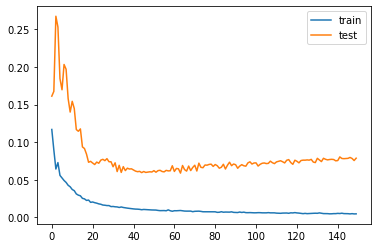

In [21]:
# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=256, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [22]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -12:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -12:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [24]:
# calculate RMSE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

evs = explained_variance_score(inv_y, inv_yhat)
print('Test EVS : %.3f' % evs)

r2=r2_score(inv_y,inv_yhat)
print('Test r2: %.3f' % r2)

Test MAE: 8.649
Test EVS : 0.801
Test r2: 0.675


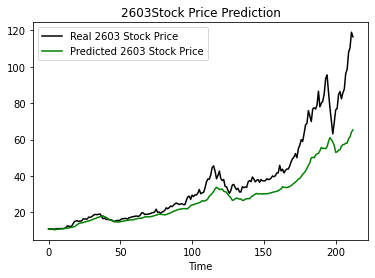

In [25]:
#用實際股價和預測的畫圖
plt.plot(inv_y, color = 'black', label = 'Real '+ name +' Stock Price ')
plt.plot(inv_yhat, color = 'green', label = 'Predicted '+name+ ' Stock Price')
plt.title(name+ 'Stock Price Prediction')
plt.xlabel('Time')
plt.legend()
plt.show()

In [26]:
#機器學習模型的評估 漲1,跌0,
def confusion_matrix_list(real,predict):
    real_tendency=[]
    predicted_tendency=[]
       
    for i in range(1,len(real)):
        if(real[i]-real[i-1]>0):
            real_tendency.append(1)
        if(real[i]-real[i-1]==0):
            real_tendency.append(2)
        if(real[i]-real[i-1]<0):
            real_tendency.append(0)
    for i in range(1,len(predict)):
        if(predict[i]-predict[i-1]>0):
            predicted_tendency.append(1)
        if(predict[i]-predict[i-1]==0):
            pedicted_tendency.append(2)
        if(predict[i]-predict[i-1]<0):
            predicted_tendency.append(0)
    
    return real_tendency,predicted_tendency 

real,predict=confusion_matrix_list(inv_y,inv_yhat)

from sklearn.metrics import confusion_matrix
matrix=confusion_matrix(real,predict,labels=[1,0,2])
print(matrix)

from sklearn.metrics import classification_report
report=classification_report(real,predict,labels=[1,0,2])
print(report)

[[102  30   0]
 [ 51  19   0]
 [  8   2   0]]
              precision    recall  f1-score   support

           1       0.63      0.77      0.70       132
           0       0.37      0.27      0.31        70
           2       0.00      0.00      0.00        10

    accuracy                           0.57       212
   macro avg       0.34      0.35      0.34       212
weighted avg       0.52      0.57      0.54       212



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
